In [91]:
import pandas as pd
import numpy as np
import random
import calendar
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

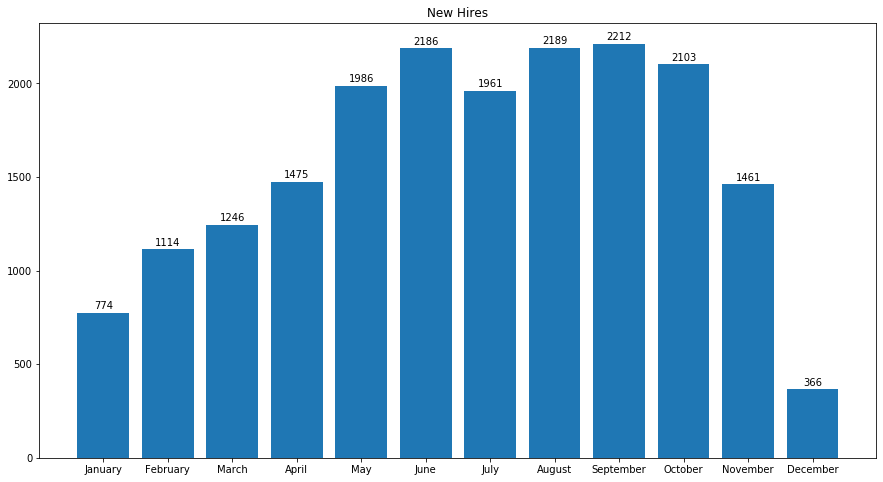

All new starters for the year:  19073.0


In [92]:
# plot new hire count in employee data

# get current working directory
cwd = os.path.abspath(os.getcwd())
# get all files in directory
files = glob.glob(cwd + "/Employee data/*")

months = []
newHires = []

for file in files:
    df = pd.read_csv(file)
    # get the count of new hires
    newHires.append(df['isNewHire'].sum())
    # get the month for the file
    months.append(pd.to_datetime(df['date'][0], dayfirst=True).month)
                 
# sort new hires based on month
newHires = [x for _,x in sorted(zip(months, newHires))]
months = sorted(months)
# replace month numbers with names
months = [calendar.month_name[i] for i in months]

# plot new hires
fig, ax = plt.subplots(figsize=(15,8))
bars = ax.bar(months, newHires)
# add data labels
for i,v in enumerate(newHires):
    ax.text(i,v+20, int(v), ha='center')
plt.title('New Hires')
plt.show()

print('All new starters for the year: ', sum(newHires))

In [93]:
n_vacancies = 20000
year = '2014'
min_date = pd.to_datetime(year + '/01/01')
max_date = pd.to_datetime(year + '/12/31')

In [94]:
# generate all vacancy data

def generate_vacancy_data(n_vacancies):
    vacancy_df = pd.DataFrame()
    # create random ids for each row
    vacancy_df['ID'] = random.sample(range(1, n_vacancies+1), n_vacancies)
    # randomly add values for FP and BU Region columns
    vacancy_df['FP'] = np.random.choice(['F','P'], n_vacancies, replace=True)
    regions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
               19, 20, 21, 22, 23, 24, 94, 95, 96, 97, 98, 99]
    vacancy_df['BU Region'] = np.random.choice(regions, n_vacancies, replace=True)
    
    # get the number of days in the time period
    n_days = (max_date - min_date).days + 1
    # generate random approved dates
    vacancy_df['Approved'] = min_date + pd.to_timedelta(np.random.randint(n_days, size=n_vacancies), unit='d')
    # add empty column filled with NaT
    vacancy_df['On hold'] = pd.NaT
    # generate 1% on hold vacancies by selecting 1% of rows
    a = vacancy_df.sample(frac=0.01)
    # generate random on hold dates for the selected rows in 10-30 days after approved date
    a['On hold'] = a['Approved'] + pd.to_timedelta(np.random.randint(low=10, high=30, size=a.shape[0]), unit='d')
    # replace modified rows in original dataset
    vacancy_df.loc[a.index, 'On hold'] = a['On hold'].dt.date
    
    # generate sourcing start date to be within 5-10 days after approved date
    vacancy_df['Sourcing start'] = vacancy_df['Approved'] + pd.to_timedelta(np.random.randint(low=5, high=10, size=n_vacancies), unit='d')
    # generate Interview start date to be within 10-20 days after sourcing start date
    vacancy_df['Interview start'] = vacancy_df['Sourcing start'] + pd.to_timedelta(np.random.randint(low=10, high=20, size=n_vacancies), unit='d')
    # generate Interview end date to be within 15-30 days after interview start date
    vacancy_df['Interview end'] = vacancy_df['Interview start'] + pd.to_timedelta(np.random.randint(low=15, high=30, size=n_vacancies), unit='d')
    # generate Offered date to be within 5-10 days after interview end date
    vacancy_df['Offered'] = vacancy_df['Interview end'] + pd.to_timedelta(np.random.randint(low=5, high=10, size=n_vacancies), unit='d')
    # generate Filled date to be within 5-10 days after offered date
    vacancy_df['Filled'] = vacancy_df['Offered'] + pd.to_timedelta(np.random.randint(low=5, high=10, size=n_vacancies), unit='d')
    
    # remove values for on hold vacancies
    vacancy_df.loc[a.index, ['Sourcing start', 'Interview start', 'Interview end', 'Offered', 'Filled']] = pd.NaT
    
    return vacancy_df

In [95]:
# generate complete dataset
vacancy_df = generate_vacancy_data(n_vacancies)
vacancy_df

,ID,FP,BU Region,Approved,On hold,Sourcing start,Interview start,Interview end,Offered,Filled
0,5792,F,1,2014-01-24,NaT,2014-01-31,2014-02-16,2014-03-11,2014-03-17,2014-03-22
1,2304,F,96,2014-06-25,NaT,2014-07-02,2014-07-18,2014-08-06,2014-08-14,2014-08-23
2,5222,F,5,2014-03-31,NaT,2014-04-07,2014-04-24,2014-05-11,2014-05-16,2014-05-23
3,17359,P,8,2014-03-27,NaT,2014-04-05,2014-04-15,2014-05-06,2014-05-11,2014-05-19
4,8494,P,23,2014-11-29,NaT,2014-12-06,2014-12-19,2015-01-14,2015-01-19,2015-01-24
...,...,...,...,...,...,...,...,...,...,...
19995,15188,P,18,2014-09-28,NaT,2014-10-03,2014-10-16,2014-11-03,2014-11-12,2014-11-21
19996,2568,F,15,2014-06-13,NaT,2014-06-19,2014-07-04,2014-07-24,2014-08-01,2014-08-09
19997,18280,F,11,2014-08-14,NaT,2014-08-20,2014-08-31,2014-09-20,2014-09-28,2014-10-07
19998,19442,F,13,2014-12-06,NaT,2014-12-14,2014-12-24,2015-01-10,2015-01-18,2015-01-24


In [96]:
# create data files for each month

def create_monthly_df(month):
    # get start date for the month
    month_start = pd.to_datetime(year + '/'+str(month)+'/01')
    # get end date for the month
    month_end = month_start + pd.to_timedelta(calendar.monthrange(int(year), month)[1]-1, unit='d')
    
    # create monthly data
    monthly_df = vacancy_df.copy()
    
    # replace dates after month end date with NaT
    monthly_df[monthly_df.columns[3:]] = monthly_df.iloc[:,3:].where(monthly_df.iloc[:,3:]<=month_end, pd.NaT)
    
    # replace rows with NaT if Filled date is in a previous month
    monthly_df[monthly_df.columns[3:]] = monthly_df.iloc[:,3:].where(
        (pd.isnull(monthly_df.iloc[:,-1])) | (monthly_df.iloc[:,-1]>=month_start), pd.NaT)
    
    # remove rows with all blank values using index
    empty_index = monthly_df[monthly_df.iloc[:,3:].isnull().all(axis=1)].index
    monthly_df = monthly_df.drop(index=empty_index).reset_index()

    # convert On hold column to datetime to be able to compare in the next step with idxmax
    monthly_df['On hold'] = pd.to_datetime(monthly_df['On hold'], errors='coerce')
    # add status column by using the max date value from the specified columns
    monthly_df['Status'] = monthly_df[['Approved', 'On hold', 'Sourcing start', 
                                       'Interview start', 'Interview end', 'Offered', 'Filled']].idxmax(axis=1)
    # remove previous index column 
    monthly_df = monthly_df.drop(['index'], axis=1)
    
    # remove NaT values
    monthly_df = monthly_df.fillna('')
    
    # write to csv
    file_name = 'Vacancy data/' +calendar.month_name[month] + '-' + year + '.csv'
    monthly_df.to_csv(file_name, index=False)

In [97]:
# generate monthly files
for i in range(12):
    create_monthly_df(i+1)

In [103]:
pd.read_csv(cwd + "/Vacancy data/April-2014.csv").fillna('').head(6)

,ID,FP,BU Region,Approved,On hold,Sourcing start,Interview start,Interview end,Offered,Filled,Status
0,5222,F,5,2014-03-31,,2014-04-07 00:00:00,2014-04-24 00:00:00,,,,Interview start
1,17359,P,8,2014-03-27,,2014-04-05 00:00:00,2014-04-15 00:00:00,,,,Interview start
2,12968,P,7,2014-04-29,,,,,,,Approved
3,18986,P,13,2014-03-16,,2014-03-22 00:00:00,2014-04-01 00:00:00,2014-04-24 00:00:00,,,Interview end
4,17926,F,97,2014-03-29,,2014-04-07 00:00:00,2014-04-20 00:00:00,,,,Interview start
5,9993,F,7,2014-02-13,,2014-02-21 00:00:00,2014-03-07 00:00:00,2014-03-26 00:00:00,2014-03-31 00:00:00,2014-04-07 00:00:00,Filled


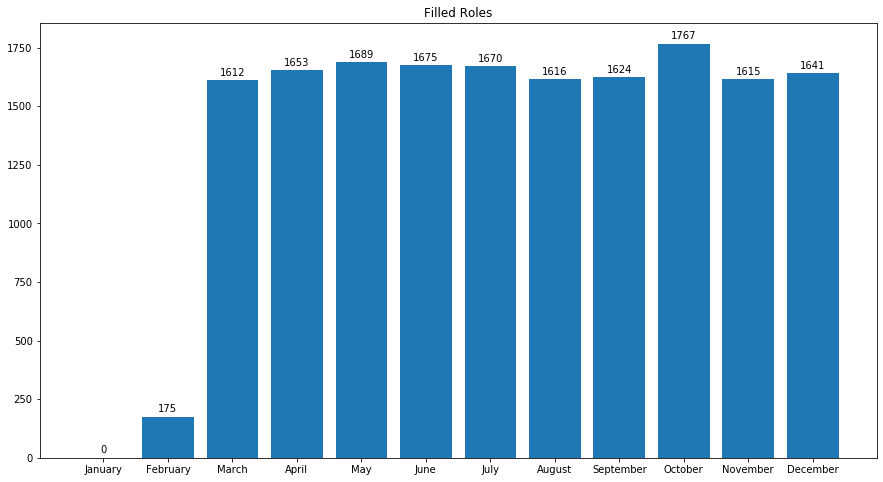

All filled roles for the year:  16737


In [98]:
# plot filled roles in vacancy data

# get all files in directory
vac_files = glob.glob(cwd + "/Vacancy data/*")

months = []
filledRoles = []

for file in vac_files:
    df = pd.read_csv(file)
    # get the count of filled roles
    filledRoles.append(df[df['Status']=='Filled']['ID'].count())
    # get the month for the file
    months.append(pd.to_datetime('1-'+file.split('/')[-1].split('.')[0], dayfirst=True).month)
                 
# sort filled roles based on month
filledRoles = [x for _,x in sorted(zip(months, filledRoles))]
months = sorted(months)
# replace month numbers with names
months = [calendar.month_name[i] for i in months]

# plot new hires
fig, ax = plt.subplots(figsize=(15,8))
bars = ax.bar(months, filledRoles)
# add data labels
for i,v in enumerate(filledRoles):
    ax.text(i,v+20, int(v), ha='center')
plt.title('Filled Roles')
plt.show()

print('All filled roles for the year: ', sum(filledRoles))